In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

100%|██████████| 3.36M/3.36M [00:00<00:00, 3.86MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


In [2]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, pearsonr, spearmanr, chi2_contingency
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Load datasets (ensure they are in the same directory or specify the full path)
stores = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Walmart Time Series /dataset/stores.csv")
features = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Walmart Time Series /dataset/features.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Walmart Time Series /dataset/train.csv")

# Convert 'Date' to datetime format
features['Date'] = pd.to_datetime(features['Date'])
train['Date'] = pd.to_datetime(train['Date'])

# Merge datasets
merged_data = train.merge(features, on=['Store', 'Date'], how='left')
merged_data = merged_data.merge(stores, on='Store', how='left')

In [4]:
merged_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [5]:
# Overview of the merged data
print("Data Info:")
print(merged_data.info())

# Summary statistics for numerical features
print("\nSummary Statistics:")
print(merged_data.describe())

# Check for missing values
print("\nMissing Values:")
print(merged_data.isnull().sum())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  IsHoliday_y   421570 non-null  bool          
 15  Type  

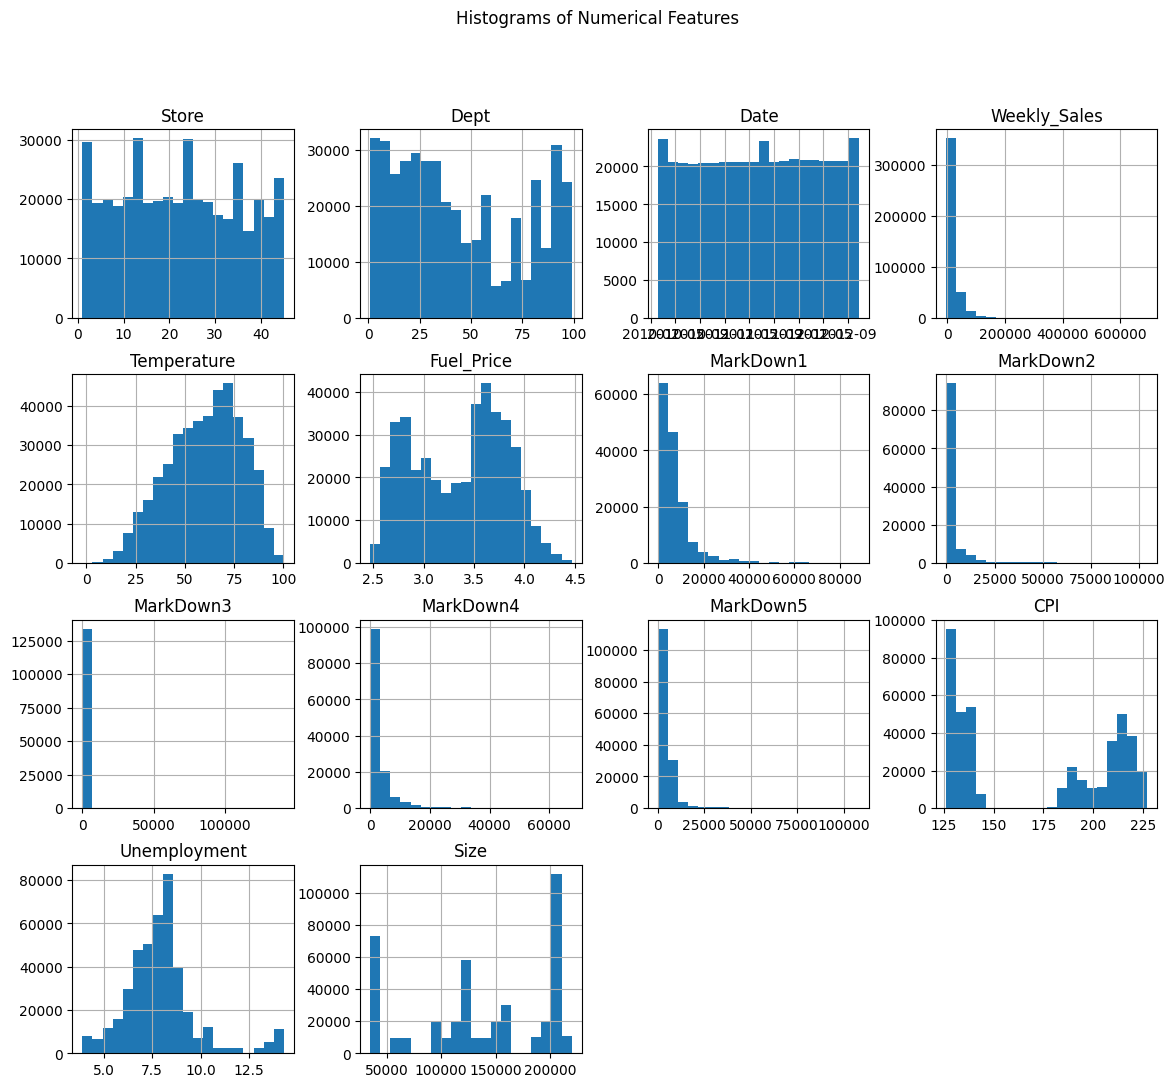

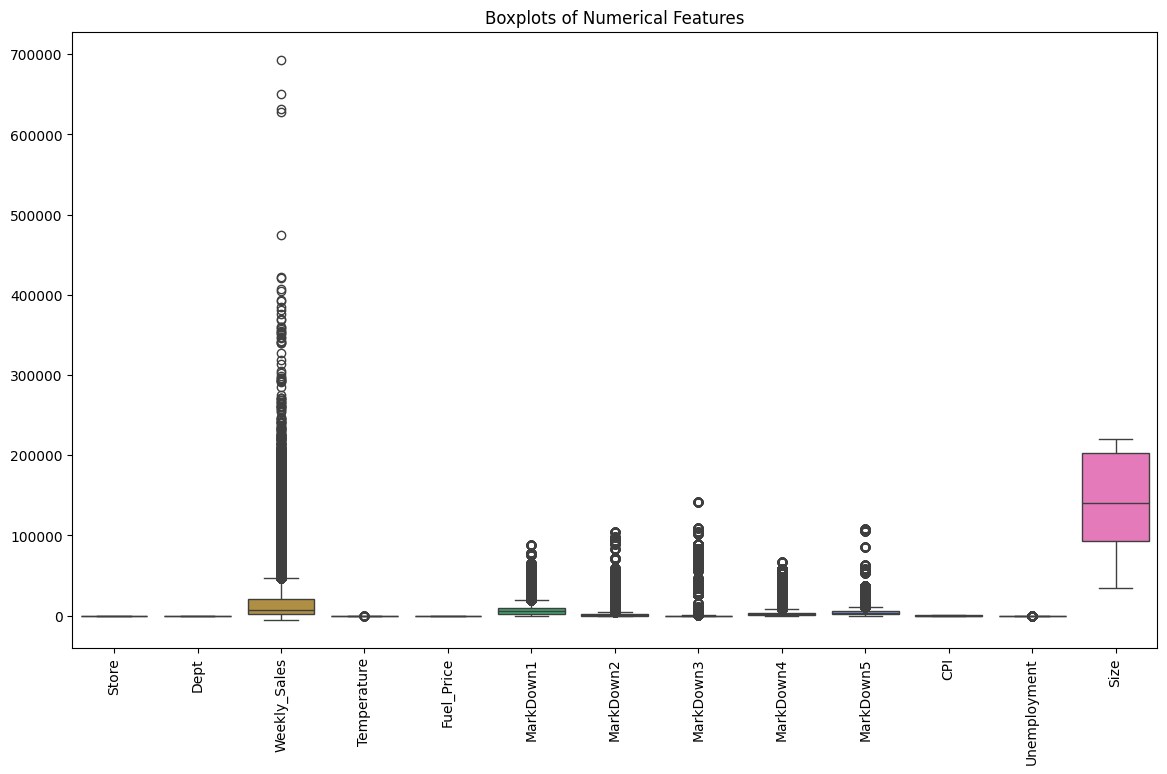

In [6]:
#Univariate Analysis
# Plot histograms for numerical features
merged_data.hist(bins=20, figsize=(14, 12))
plt.suptitle("Histograms of Numerical Features")
plt.show()

# Plot boxplots for numerical features to detect outliers
plt.figure(figsize=(14, 8))
sns.boxplot(data=merged_data.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.title("Boxplots of Numerical Features")
plt.show()

In [7]:
from scipy.stats import shapiro

numerical_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in numerical_cols:
    stat, p_value = shapiro(merged_data[col].dropna())

    print(f"{col} - Shapiro-Wilk Test: p-value = {p_value}")
    if p_value > 0.05:
        print(f"{col} follows a normal distribution.")
    else:
        print(f"{col} does not follow a normal distribution.")

    print("\n")

Weekly_Sales - Shapiro-Wilk Test: p-value = 4.061808879748697e-180
Weekly_Sales does not follow a normal distribution.


Temperature - Shapiro-Wilk Test: p-value = 1.9602652685776882e-94
Temperature does not follow a normal distribution.


Fuel_Price - Shapiro-Wilk Test: p-value = 5.3984176379964e-119
Fuel_Price does not follow a normal distribution.


CPI - Shapiro-Wilk Test: p-value = 6.198655528720937e-165
CPI does not follow a normal distribution.


Unemployment - Shapiro-Wilk Test: p-value = 2.7771505432994173e-140
Unemployment does not follow a normal distribution.




/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 421570.
  res = hypotest_fun_out(*samples, **kwds)


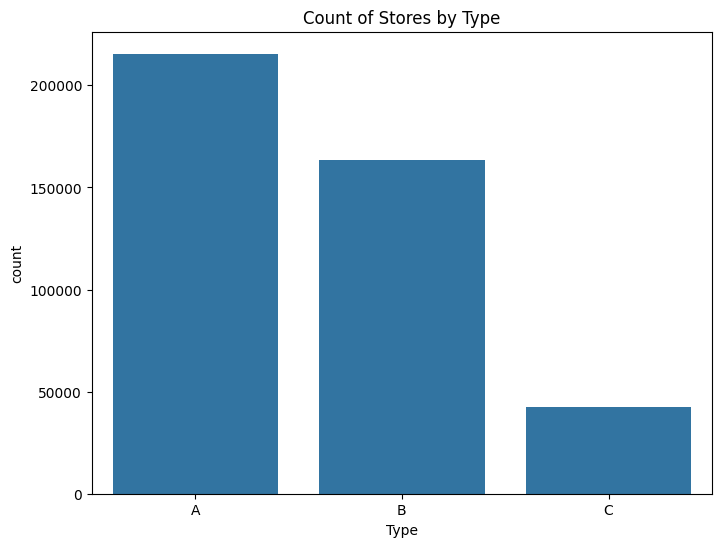

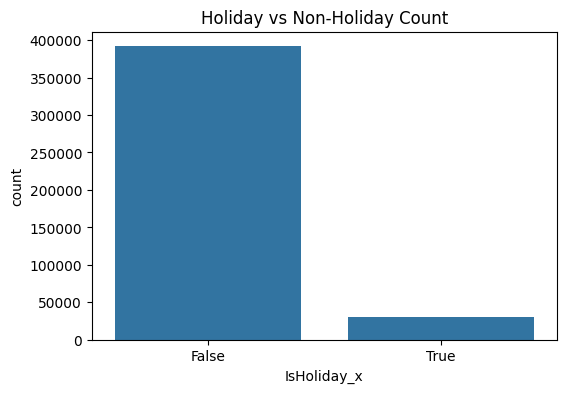

In [8]:
#Count plot for Store Type
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', data=merged_data)
plt.title("Count of Stores by Type")
plt.show()

print("\n")

# Count of holiday vs non-holiday
plt.figure(figsize=(6, 4))
sns.countplot(x='IsHoliday_x', data=merged_data)
plt.title("Holiday vs Non-Holiday Count")
plt.show()

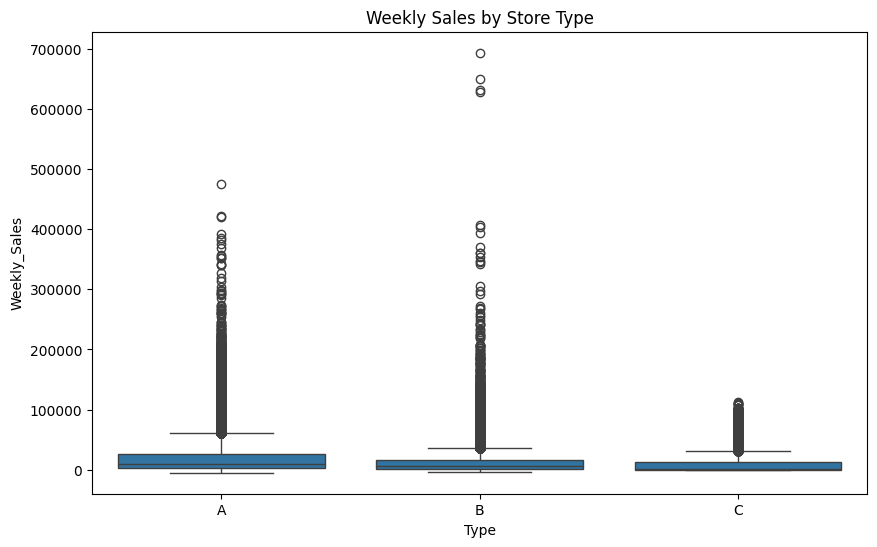

In [9]:
#Bivariate Analysis

plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='Type', y='Weekly_Sales')
plt.title("Weekly Sales by Store Type")
plt.show()


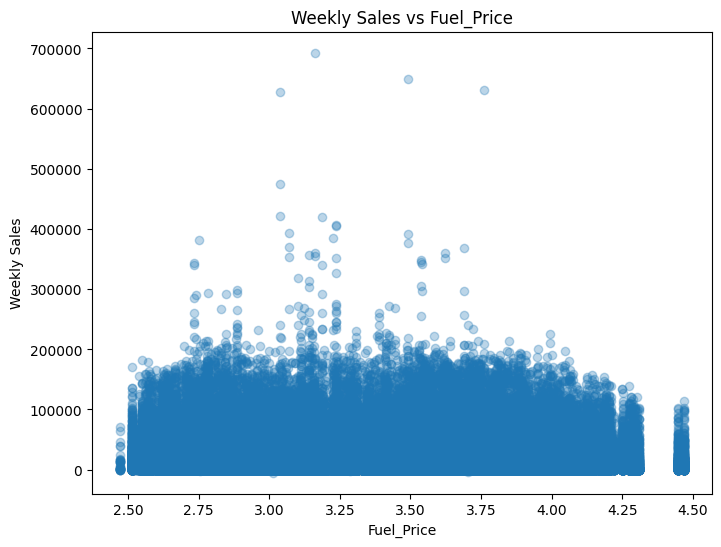

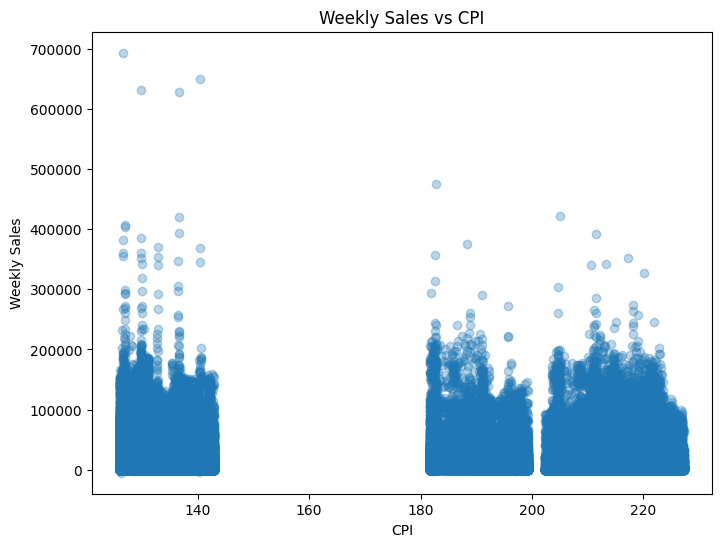

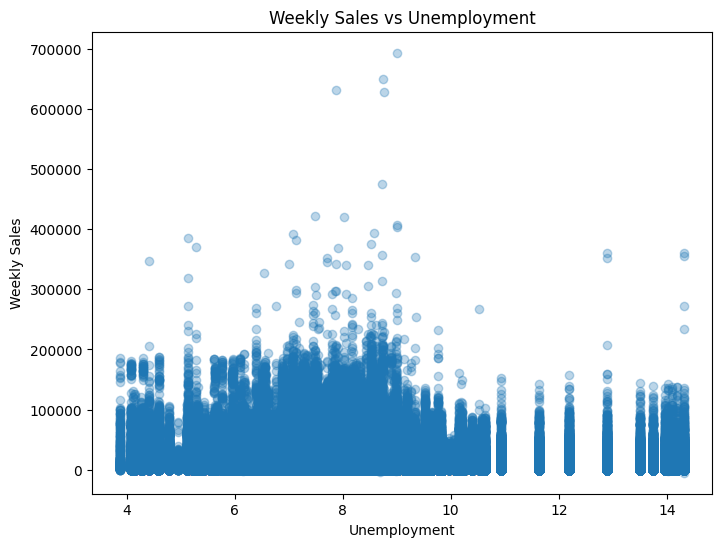

In [10]:
#Sales vs Economic Indicators

economic_cols = ['Fuel_Price', 'CPI', 'Unemployment']
for col in economic_cols:
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_data[col], merged_data['Weekly_Sales'], alpha=0.3)
    plt.title(f"Weekly Sales vs {col}")
    plt.xlabel(col)
    plt.ylabel("Weekly Sales")
    plt.show()


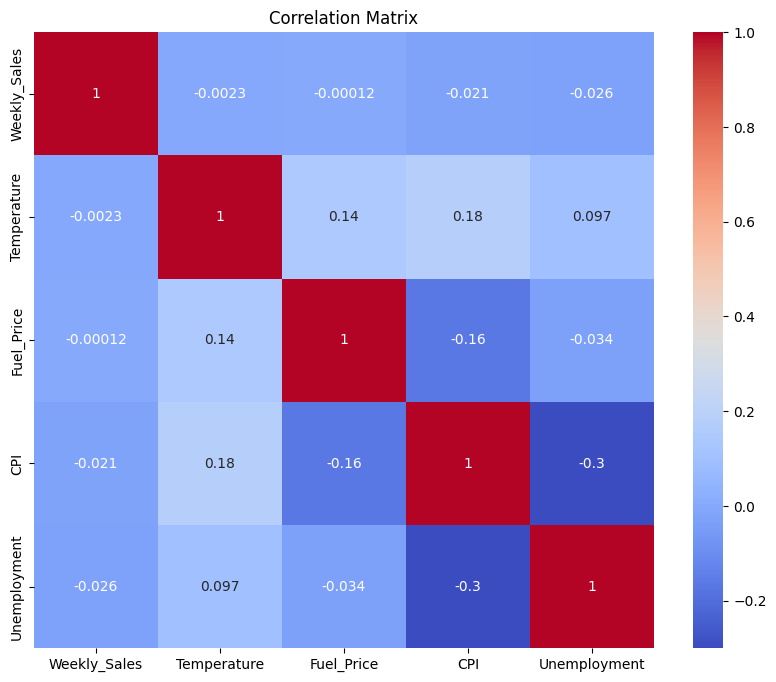

In [11]:
correlations = merged_data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


## Statistical test

In [12]:
#t-test
holiday_sales = merged_data[merged_data['IsHoliday_x'] == True]['Weekly_Sales']
non_holiday_sales = merged_data[merged_data['IsHoliday_x'] == False]['Weekly_Sales']

t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales, nan_policy='omit')
print(f"T-Test for Holiday vs Non-Holiday Sales: T-Statistic = {t_stat}, P-Value = {p_value}")


T-Test for Holiday vs Non-Holiday Sales: T-Statistic = 8.294756853931894, P-Value = 1.0912222677432845e-16


In [13]:
#Chi-Square test
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    contingency_table = pd.crosstab(merged_data['Type'], merged_data[col].isnull())
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {col} and Store Type: p-value = {p}")


Chi-Square Test for MarkDown1 and Store Type: p-value = 0.02298049187774225
Chi-Square Test for MarkDown2 and Store Type: p-value = 0.0
Chi-Square Test for MarkDown3 and Store Type: p-value = 4.0633081515848286e-82
Chi-Square Test for MarkDown4 and Store Type: p-value = 0.0
Chi-Square Test for MarkDown5 and Store Type: p-value = 0.014433611379391498


#Time Series Analysis

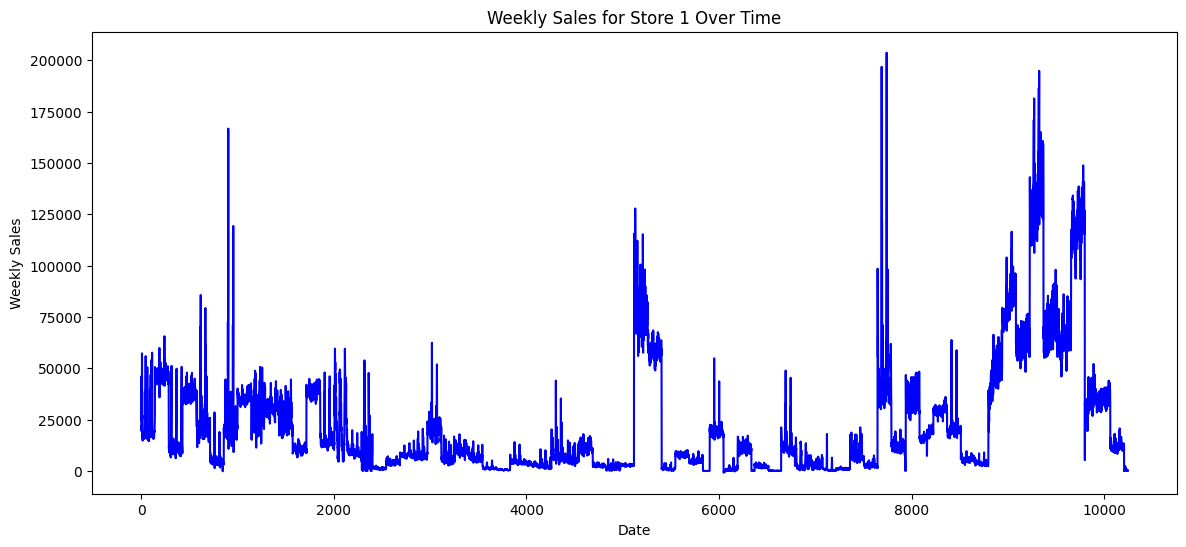

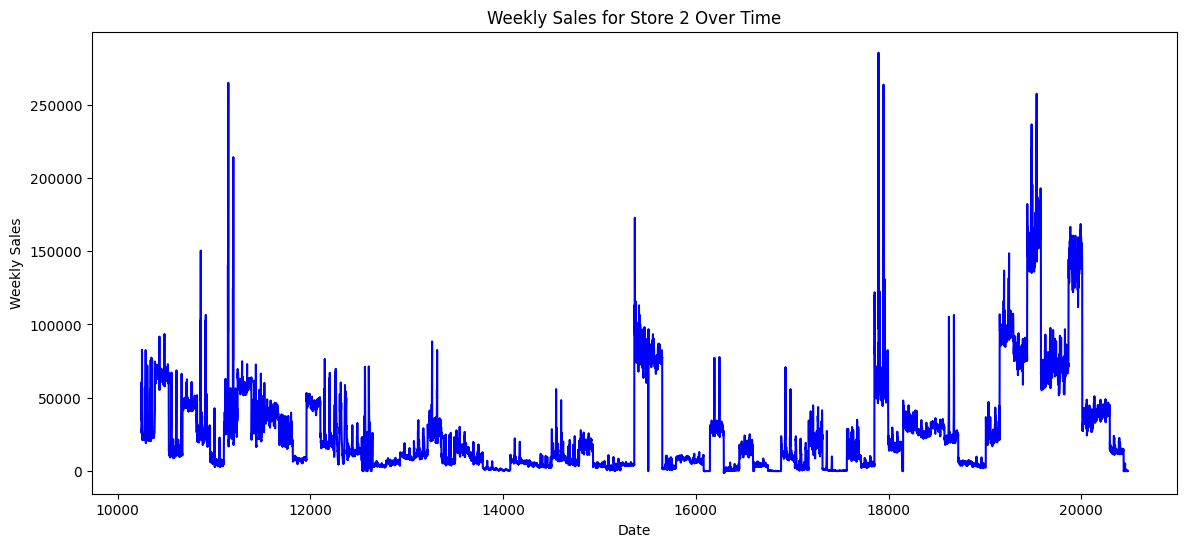

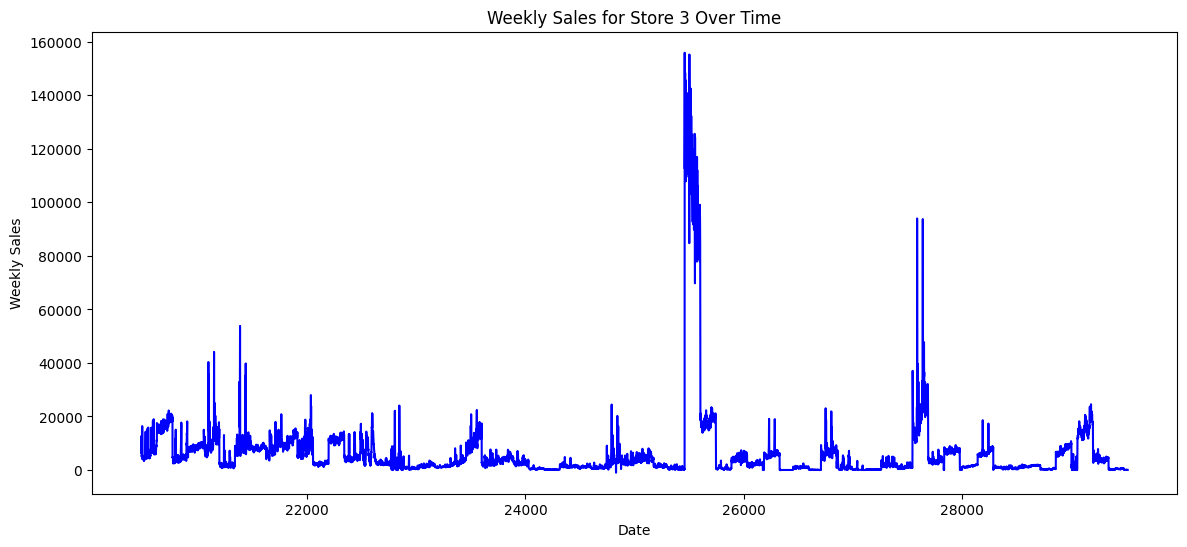

In [14]:
# List of store IDs to plot
stores_to_plot = [1, 2, 3]  # Replace with actual store IDs you want to plot

# Plot weekly sales for each store
for store_id in stores_to_plot:
    store_data = merged_data[merged_data['Store'] == store_id]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(store_data.index, store_data['Weekly_Sales'], color='blue')
    plt.title(f"Weekly Sales for Store {store_id} Over Time")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.show()

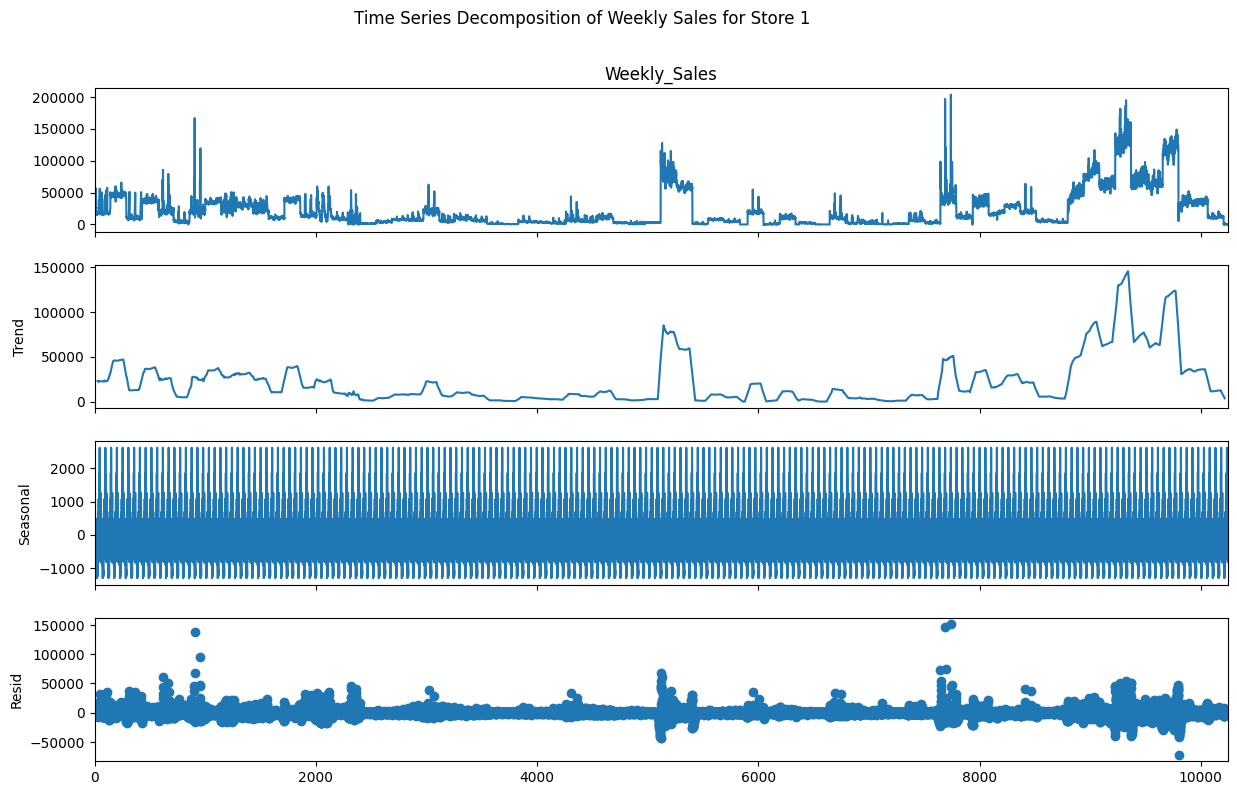

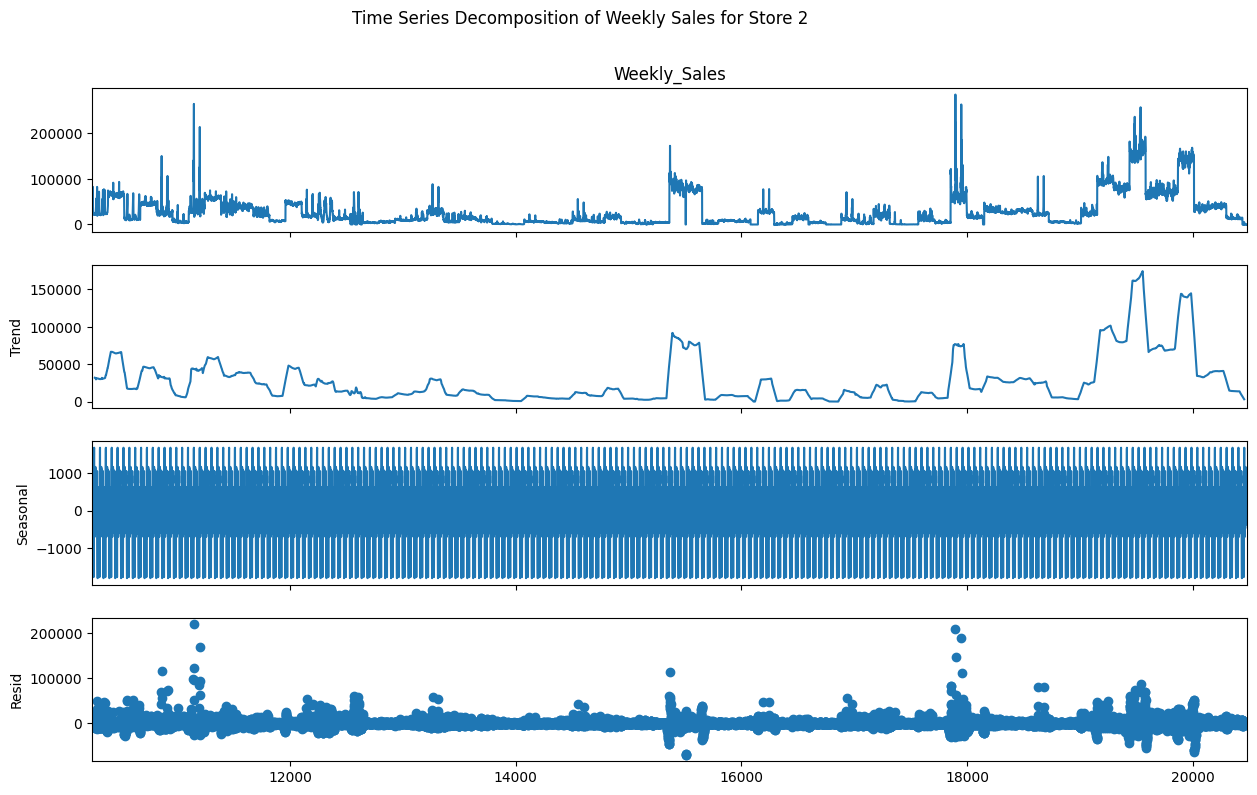

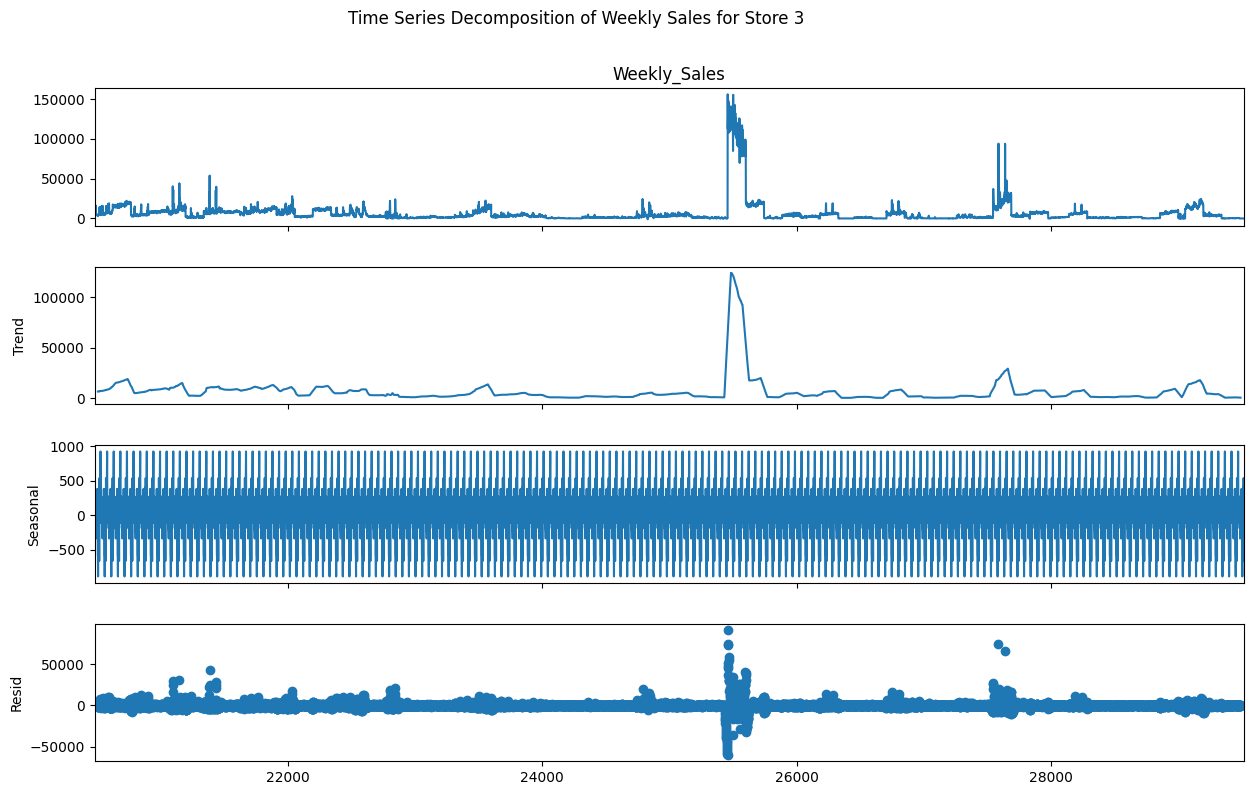

In [15]:
stores_to_decompose = [1, 2, 3]  # Replace with the specific store IDs you want to analyze

# Perform decomposition for each store
for store_id in stores_to_decompose:
    # Filter data for the specific store
    store_data = merged_data[merged_data['Store'] == store_id]

    # Ensure there is enough data for decomposition by checking the length
    if len(store_data) >= 52:
        # Decompose the time series (weekly sales) for the store
        decomposition = seasonal_decompose(store_data['Weekly_Sales'], model='additive', period=52)

        # Plot the decomposition results
        fig = decomposition.plot()
        fig.set_size_inches(14, 8)
        plt.suptitle(f"Time Series Decomposition of Weekly Sales for Store {store_id}", y=1.02)
        plt.show()
    else:
        print(f"Not enough data for decomposition for Store {store_id}. Minimum 52 weeks required.")

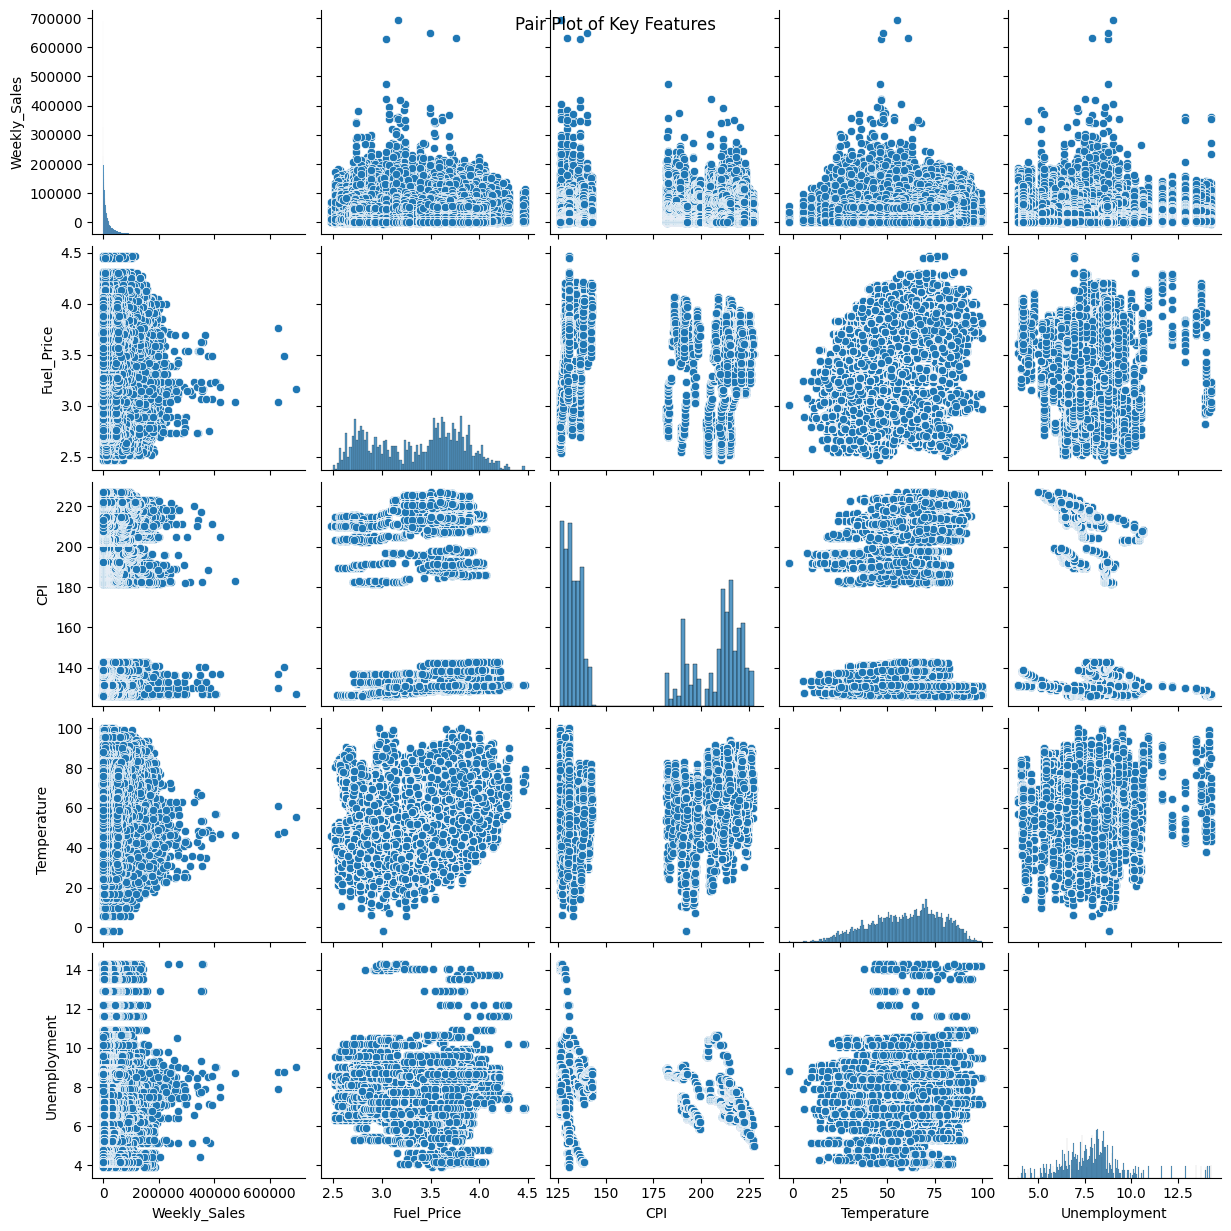

In [16]:
sns.pairplot(merged_data[['Weekly_Sales', 'Fuel_Price', 'CPI', 'Temperature', 'Unemployment']])
plt.suptitle("Pair Plot of Key Features")
plt.show()


In [19]:
merged_data.to_csv('/content/drive/MyDrive/Colab Notebooks/Walmart Time Series /dataset/merged_data.csv', index=False)

In [18]:
merged_data

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False,B,118221
